<a href="https://colab.research.google.com/github/ahmad1adel/GANs-for-Orthognathic-Surgery-GP-/blob/main/GANs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q tensorflow matplotlib

import os
import tensorflow as tf
import matplotlib.pyplot as plt
from glob import glob
from PIL import Image
import numpy as np

In [ ]:
import os
from glob import glob

print(glob("/content/drive/MyDrive/GANs dataset/train_no_bg/before/*.png"))
print(glob("/content/drive/MyDrive/GANs dataset/train_no_bg/after/*.png"))

['/content/drive/MyDrive/GANs dataset/train_no_bg/before/1.png', '/content/drive/MyDrive/GANs dataset/train_no_bg/before/10.png', '/content/drive/MyDrive/GANs dataset/train_no_bg/before/100.png', '/content/drive/MyDrive/GANs dataset/train_no_bg/before/11.png', '/content/drive/MyDrive/GANs dataset/train_no_bg/before/12.png', '/content/drive/MyDrive/GANs dataset/train_no_bg/before/13.png', '/content/drive/MyDrive/GANs dataset/train_no_bg/before/14.png', '/content/drive/MyDrive/GANs dataset/train_no_bg/before/15.png', '/content/drive/MyDrive/GANs dataset/train_no_bg/before/16.png', '/content/drive/MyDrive/GANs dataset/train_no_bg/before/17.png', '/content/drive/MyDrive/GANs dataset/train_no_bg/before/18.png', '/content/drive/MyDrive/GANs dataset/train_no_bg/before/19.png', '/content/drive/MyDrive/GANs dataset/train_no_bg/before/2.png', '/content/drive/MyDrive/GANs dataset/train_no_bg/before/20.png', '/content/drive/MyDrive/GANs dataset/train_no_bg/before/21.png', '/content/drive/MyDrive/G

In [ ]:
from PIL import Image
import numpy as np
import tensorflow as tf
import os
from glob import glob

INPUT_DIR = "/content/drive/MyDrive/GANs dataset/train_no_bg/before"
TARGET_DIR = "/content/drive/MyDrive/GANs dataset/train_no_bg/after"

IMG_SIZE = 256


def load_image(path):
    image = Image.open(path).convert("L").resize((IMG_SIZE, IMG_SIZE))
    image = np.array(image) / 255.0
    image = image.reshape((IMG_SIZE, IMG_SIZE, 1))
    return image.astype(np.float32)

# تحميل كل الصور من before/after
input_paths = sorted(glob(os.path.join(INPUT_DIR, "*.png")))
target_paths = sorted(glob(os.path.join(TARGET_DIR, "*.png")))

# تأكد إنهم متساويين
assert len(input_paths) == len(target_paths), "❌ عدد الصور غير متطابق بين before و after"

# تحميل الصور
input_images = [load_image(p) for p in input_paths]
target_images = [load_image(p) for p in target_paths]

# تحويلهم إلى Tensors
input_images = tf.convert_to_tensor(input_images)
target_images = tf.convert_to_tensor(target_images)

print(f"✅ Loaded {len(input_images)} image pairs. Shape: {input_images.shape}")


✅ Loaded 100 image pairs. Shape: (100, 256, 256, 1)


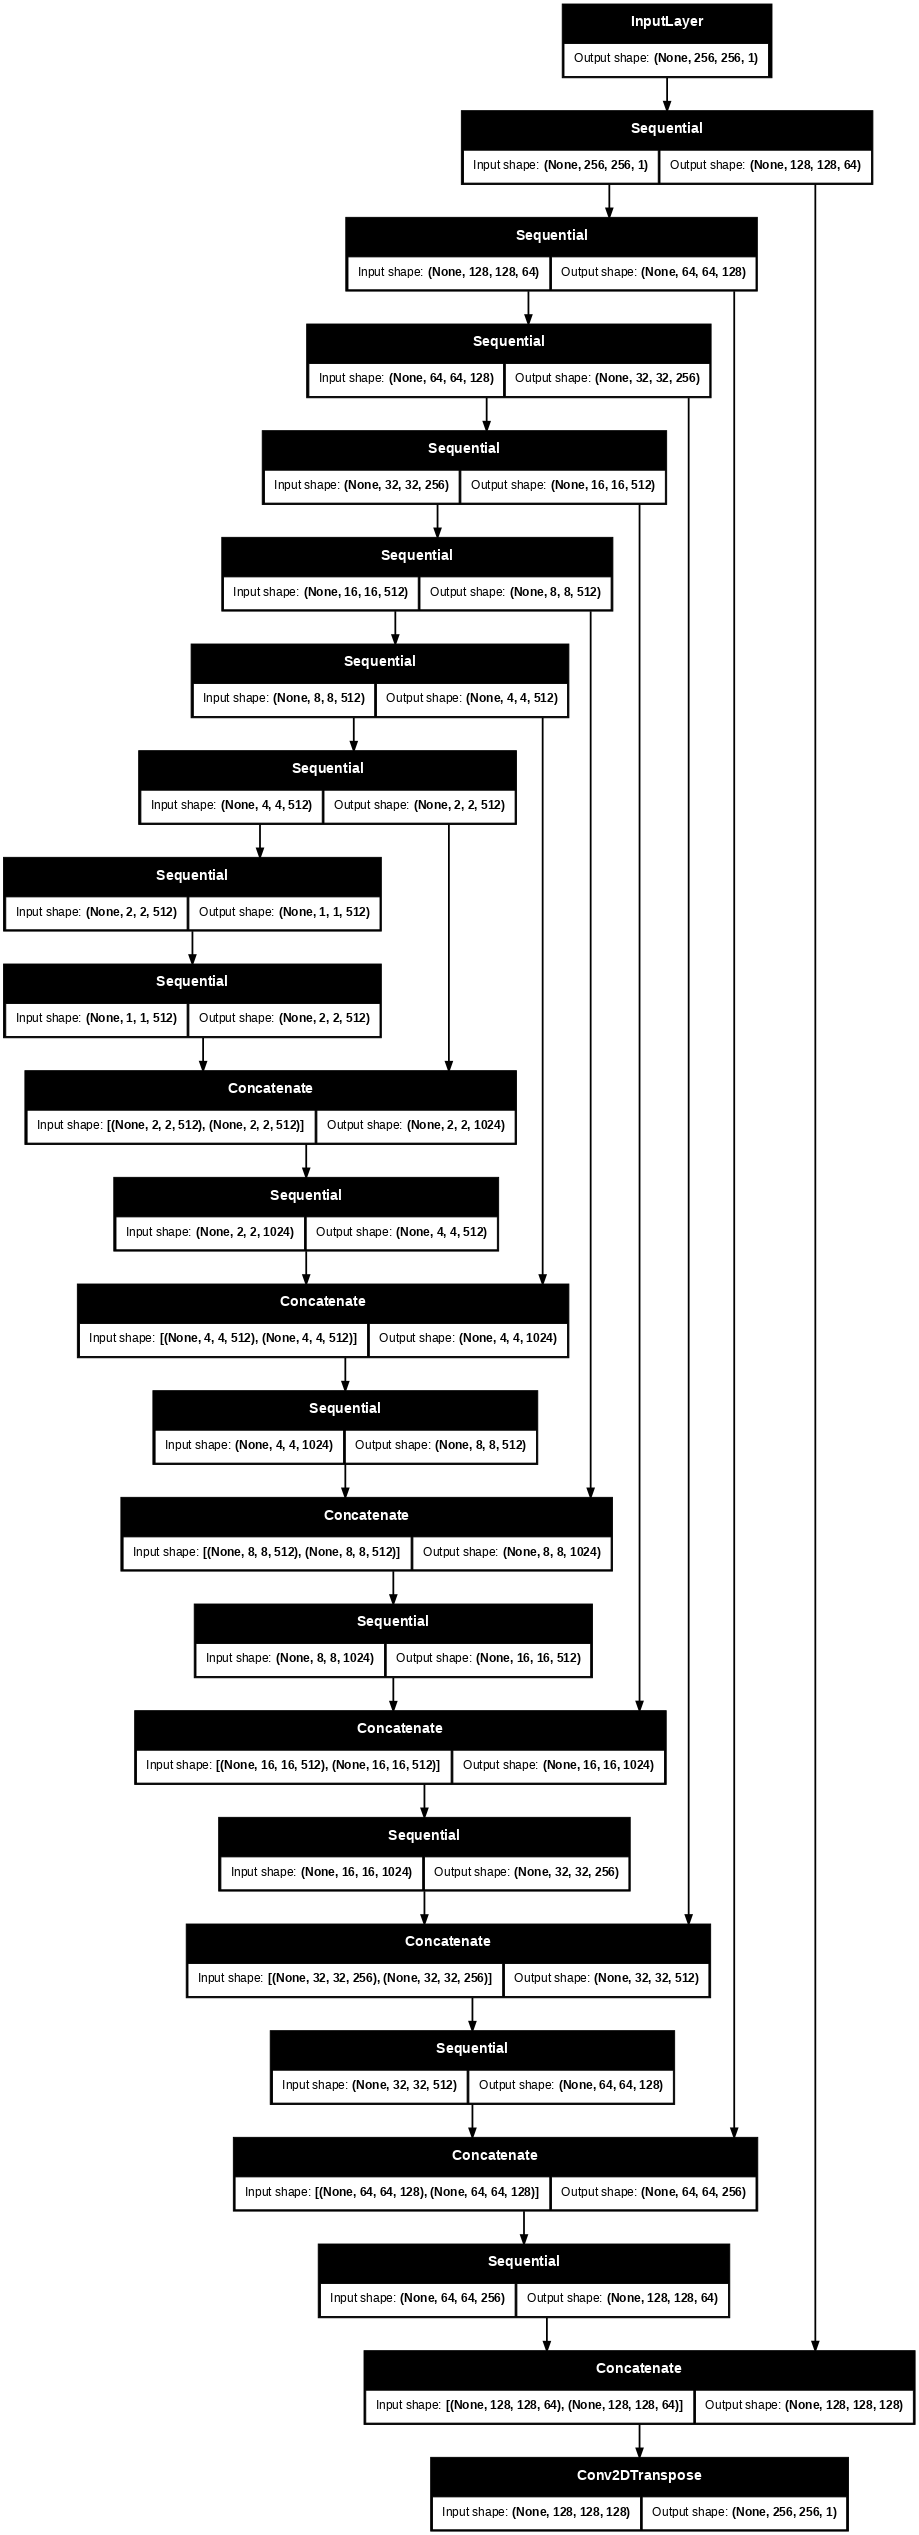

In [ ]:
from tensorflow.keras import layers

def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    block = tf.keras.Sequential()
    block.add(layers.Conv2D(filters, size, strides=2, padding='same',
                            kernel_initializer=initializer, use_bias=False))
    if apply_batchnorm:
        block.add(layers.BatchNormalization())
    block.add(layers.LeakyReLU())
    return block

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    block = tf.keras.Sequential()
    block.add(layers.Conv2DTranspose(filters, size, strides=2,
                                     padding='same',
                                     kernel_initializer=initializer,
                                     use_bias=False))
    block.add(layers.BatchNormalization())
    if apply_dropout:
        block.add(layers.Dropout(0.5))
    block.add(layers.ReLU())
    return block

def Generator():
    inputs = layers.Input(shape=[256, 256, 1])

    # Encoder
    down_stack = [
        downsample(64, 4, apply_batchnorm=False),
        downsample(128, 4),
        downsample(256, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
    ]

    # Decoder
    up_stack = [
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4),
        upsample(256, 4),
        upsample(128, 4),
        upsample(64, 4),
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(1, 4, strides=2,  # ✅ Single-channel output
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh')  # Output range [-1, 1]

    x = inputs
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    skips = reversed(skips[:-1])

    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

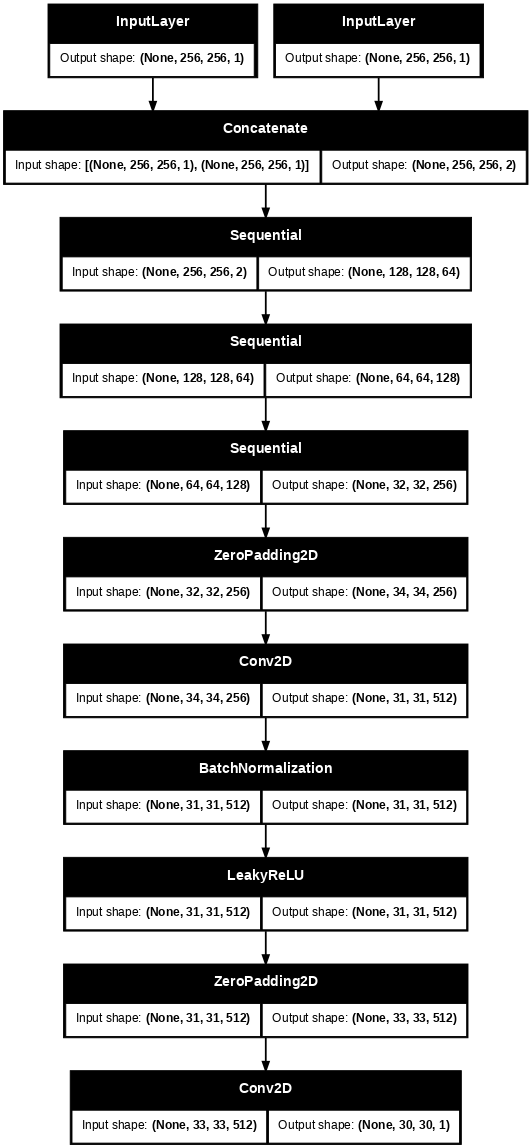

In [ ]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    # ✅ مدخلات الصور بالـ Grayscale
    inp = layers.Input(shape=[256, 256, 1], name='input_image')   # jaw before
    tar = layers.Input(shape=[256, 256, 1], name='target_image')  # jaw after

    x = layers.concatenate([inp, tar])  # دمج القناتين

    down1 = downsample(64, 4, False)(x)
    down2 = downsample(128, 4)(down1)
    down3 = downsample(256, 4)(down2)

    zero_pad1 = layers.ZeroPadding2D()(down3)
    conv = layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer,
                         use_bias=False)(zero_pad1)

    batchnorm1 = layers.BatchNormalization()(conv)
    leaky_relu = layers.LeakyReLU()(batchnorm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu)

    last = layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(zero_pad2)

    return tf.keras.Model(inputs=[inp, tar], outputs=last)

discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

In [ ]:
# Cell 5: Define losses and optimizers

# Binary Cross Entropy Loss
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# Loss for Generator
def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

    total_gen_loss = gan_loss + (100 * l1_loss)

    return {
        "gen_total_loss": total_gen_loss,
        "gen_gan_loss": gan_loss,
        "gen_l1_loss": l1_loss
    }

# Loss for Discriminator
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

    total_disc_loss = real_loss + generated_loss
    return total_disc_loss

generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)


In [ ]:
# Cell 6: Training Step
@tf.function
def train_step(input_image, target, generator, discriminator):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_losses = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_losses["gen_total_loss"], generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

    return {
        "gen_total_loss": gen_losses["gen_total_loss"],
        "gen_gan_loss": gen_losses["gen_gan_loss"],
        "gen_l1_loss": gen_losses["gen_l1_loss"],
        "disc_loss": disc_loss,
    }


In [ ]:
BATCH_SIZE = 1
BUFFER_SIZE = 100

def normalize(input_image, target_image):
    input_image = (tf.cast(input_image, tf.float32) / 127.5) - 1
    target_image = (tf.cast(target_image, tf.float32) / 127.5) - 1
    return input_image, target_image

train_dataset = tf.data.Dataset.from_tensor_slices((input_images, target_images))
train_dataset = train_dataset.map(normalize)
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


In [ ]:
EPOCHS = 100
CHECKPOINT_DIR = "/content/drive/MyDrive/jaw_pix2pix_checkpoints"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

def save_models(epoch):
    generator.save(os.path.join(CHECKPOINT_DIR, f"generator_epoch_{epoch+1}.h5"))
    discriminator.save(os.path.join(CHECKPOINT_DIR, f"discriminator_epoch_{epoch+1}.h5"))

def generate_sample_output(generator, input_image, target, epoch):
    prediction = generator(tf.expand_dims(input_image, 0), training=True)[0]
    prediction = (prediction + 1) / 2

    plt.figure(figsize=(12, 4))
    display_list = [input_image, target, prediction]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        img = (display_list[i] + 1) / 2 if i != 2 else display_list[i]
        plt.imshow(img.numpy())
        plt.axis('off')
    plt.savefig(f"/content/sample_epoch_{epoch+1}.png")
    plt.close()

def fit(train_dataset, generator, discriminator, log_interval=10):
    for step, (input_image, target) in enumerate(train_dataset):
        losses = train_step(input_image, target, generator, discriminator)

        if (step + 1) % log_interval == 0:
            print(f"Step {step+1}")
            print(f"  Generator total loss: {losses['gen_total_loss']:.4f}")
            print(f"  Generator GAN loss:   {losses['gen_gan_loss']:.4f}")
            print(f"  Generator L1 loss:    {losses['gen_l1_loss']:.4f}")
            print(f"  Discriminator loss:   {losses['disc_loss']:.4f}")
            print("-" * 40)

for epoch in range(EPOCHS):
    print(f"\n🔁 Epoch {epoch + 1}/{EPOCHS}")
    fit(train_dataset, generator, discriminator)

    if (epoch + 1) % 10 == 0:
        sample_input, sample_target = next(iter(train_dataset))
        generate_sample_output(generator, sample_input[0], sample_target[0], epoch)
        save_models(epoch)


🔁 Epoch 1/100
Step 10
  Generator total loss: 59.1125
  Generator GAN loss:   2.2917
  Generator L1 loss:    0.5682
  Discriminator loss:   0.2956
----------------------------------------
Step 20
  Generator total loss: 40.2435
  Generator GAN loss:   3.5543
  Generator L1 loss:    0.3669
  Discriminator loss:   0.0693
----------------------------------------
Step 30
  Generator total loss: 27.7978
  Generator GAN loss:   4.4125
  Generator L1 loss:    0.2339
  Discriminator loss:   0.0354
----------------------------------------
Step 40
  Generator total loss: 17.4219
  Generator GAN loss:   2.5835
  Generator L1 loss:    0.1484
  Discriminator loss:   1.9158
----------------------------------------
Step 50
  Generator total loss: 10.6078
  Generator GAN loss:   1.0124
  Generator L1 loss:    0.0960
  Discriminator loss:   0.7659
----------------------------------------
Step 60
  Generator total loss: 7.2463
  Generator GAN loss:   0.4341
  Generator L1 loss:    0.0681
  Discriminato


🔁 Epoch 11/100
Step 10
  Generator total loss: 0.7934
  Generator GAN loss:   0.6783
  Generator L1 loss:    0.0012
  Discriminator loss:   1.3897
----------------------------------------
Step 20
  Generator total loss: 0.8380
  Generator GAN loss:   0.6964
  Generator L1 loss:    0.0014
  Discriminator loss:   1.4093
----------------------------------------
Step 30
  Generator total loss: 0.8187
  Generator GAN loss:   0.6856
  Generator L1 loss:    0.0013
  Discriminator loss:   1.3996
----------------------------------------
Step 40
  Generator total loss: 0.8507
  Generator GAN loss:   0.7266
  Generator L1 loss:    0.0012
  Discriminator loss:   1.4018
----------------------------------------
Step 50
  Generator total loss: 0.8358
  Generator GAN loss:   0.6791
  Generator L1 loss:    0.0016
  Discriminator loss:   1.4165
----------------------------------------
Step 60
  Generator total loss: 0.8137
  Generator GAN loss:   0.6941
  Generator L1 loss:    0.0012
  Discriminator lo


🔁 Epoch 21/100
Step 10
  Generator total loss: 0.7992
  Generator GAN loss:   0.7006
  Generator L1 loss:    0.0010
  Discriminator loss:   1.3940
----------------------------------------
Step 20
  Generator total loss: 0.7945
  Generator GAN loss:   0.7032
  Generator L1 loss:    0.0009
  Discriminator loss:   1.3854
----------------------------------------
Step 30
  Generator total loss: 0.8212
  Generator GAN loss:   0.6893
  Generator L1 loss:    0.0013
  Discriminator loss:   1.3920
----------------------------------------
Step 40
  Generator total loss: 0.7782
  Generator GAN loss:   0.6792
  Generator L1 loss:    0.0010
  Discriminator loss:   1.3511
----------------------------------------
Step 50
  Generator total loss: 0.8919
  Generator GAN loss:   0.7353
  Generator L1 loss:    0.0016
  Discriminator loss:   1.3829
----------------------------------------
Step 60
  Generator total loss: 0.8306
  Generator GAN loss:   0.6995
  Generator L1 loss:    0.0013
  Discriminator lo


🔁 Epoch 31/100
Step 10
  Generator total loss: 0.7985
  Generator GAN loss:   0.6904
  Generator L1 loss:    0.0011
  Discriminator loss:   1.4204
----------------------------------------
Step 20
  Generator total loss: 0.8258
  Generator GAN loss:   0.6844
  Generator L1 loss:    0.0014
  Discriminator loss:   1.4081
----------------------------------------
Step 30
  Generator total loss: 0.8064
  Generator GAN loss:   0.6948
  Generator L1 loss:    0.0011
  Discriminator loss:   1.3782
----------------------------------------
Step 40
  Generator total loss: 0.7845
  Generator GAN loss:   0.7105
  Generator L1 loss:    0.0007
  Discriminator loss:   1.3692
----------------------------------------
Step 50
  Generator total loss: 0.8141
  Generator GAN loss:   0.7012
  Generator L1 loss:    0.0011
  Discriminator loss:   1.4030
----------------------------------------
Step 60
  Generator total loss: 0.7593
  Generator GAN loss:   0.7033
  Generator L1 loss:    0.0006
  Discriminator lo


🔁 Epoch 41/100
Step 10
  Generator total loss: 0.7894
  Generator GAN loss:   0.6961
  Generator L1 loss:    0.0009
  Discriminator loss:   1.3967
----------------------------------------
Step 20
  Generator total loss: 0.7562
  Generator GAN loss:   0.6914
  Generator L1 loss:    0.0006
  Discriminator loss:   1.3865
----------------------------------------
Step 30
  Generator total loss: 0.7998
  Generator GAN loss:   0.7124
  Generator L1 loss:    0.0009
  Discriminator loss:   1.4050
----------------------------------------
Step 40
  Generator total loss: 0.7617
  Generator GAN loss:   0.6866
  Generator L1 loss:    0.0008
  Discriminator loss:   1.3892
----------------------------------------
Step 50
  Generator total loss: 0.7878
  Generator GAN loss:   0.7194
  Generator L1 loss:    0.0007
  Discriminator loss:   1.3841
----------------------------------------
Step 60
  Generator total loss: 0.7670
  Generator GAN loss:   0.7048
  Generator L1 loss:    0.0006
  Discriminator lo


🔁 Epoch 51/100
Step 10
  Generator total loss: 0.7663
  Generator GAN loss:   0.7000
  Generator L1 loss:    0.0007
  Discriminator loss:   1.3909
----------------------------------------
Step 20
  Generator total loss: 0.7485
  Generator GAN loss:   0.6821
  Generator L1 loss:    0.0007
  Discriminator loss:   1.3834
----------------------------------------
Step 30
  Generator total loss: 0.7243
  Generator GAN loss:   0.6766
  Generator L1 loss:    0.0005
  Discriminator loss:   1.3847
----------------------------------------
Step 40
  Generator total loss: 0.8022
  Generator GAN loss:   0.7317
  Generator L1 loss:    0.0007
  Discriminator loss:   1.3985
----------------------------------------
Step 50
  Generator total loss: 0.7394
  Generator GAN loss:   0.6895
  Generator L1 loss:    0.0005
  Discriminator loss:   1.3915
----------------------------------------
Step 60
  Generator total loss: 0.7407
  Generator GAN loss:   0.6690
  Generator L1 loss:    0.0007
  Discriminator lo


🔁 Epoch 61/100
Step 10
  Generator total loss: 0.7352
  Generator GAN loss:   0.6805
  Generator L1 loss:    0.0005
  Discriminator loss:   1.3927
----------------------------------------
Step 20
  Generator total loss: 0.7574
  Generator GAN loss:   0.7076
  Generator L1 loss:    0.0005
  Discriminator loss:   1.3968
----------------------------------------
Step 30
  Generator total loss: 0.7408
  Generator GAN loss:   0.6880
  Generator L1 loss:    0.0005
  Discriminator loss:   1.3877
----------------------------------------
Step 40
  Generator total loss: 0.7488
  Generator GAN loss:   0.7049
  Generator L1 loss:    0.0004
  Discriminator loss:   1.3823
----------------------------------------
Step 50
  Generator total loss: 0.7643
  Generator GAN loss:   0.7038
  Generator L1 loss:    0.0006
  Discriminator loss:   1.3856
----------------------------------------
Step 60
  Generator total loss: 0.7566
  Generator GAN loss:   0.6991
  Generator L1 loss:    0.0006
  Discriminator lo


🔁 Epoch 71/100
Step 10
  Generator total loss: 0.7377
  Generator GAN loss:   0.7031
  Generator L1 loss:    0.0003
  Discriminator loss:   1.3918
----------------------------------------
Step 20
  Generator total loss: 0.7384
  Generator GAN loss:   0.6895
  Generator L1 loss:    0.0005
  Discriminator loss:   1.3873
----------------------------------------
Step 30
  Generator total loss: 0.7310
  Generator GAN loss:   0.6929
  Generator L1 loss:    0.0004
  Discriminator loss:   1.3907
----------------------------------------
Step 40
  Generator total loss: 0.7433
  Generator GAN loss:   0.7022
  Generator L1 loss:    0.0004
  Discriminator loss:   1.3870
----------------------------------------
Step 50
  Generator total loss: 0.7415
  Generator GAN loss:   0.7011
  Generator L1 loss:    0.0004
  Discriminator loss:   1.3873
----------------------------------------
Step 60
  Generator total loss: 0.7470
  Generator GAN loss:   0.6925
  Generator L1 loss:    0.0005
  Discriminator lo


🔁 Epoch 81/100
Step 10
  Generator total loss: 0.7305
  Generator GAN loss:   0.6793
  Generator L1 loss:    0.0005
  Discriminator loss:   1.3823
----------------------------------------
Step 20
  Generator total loss: 0.7475
  Generator GAN loss:   0.7054
  Generator L1 loss:    0.0004
  Discriminator loss:   1.3809
----------------------------------------
Step 30
  Generator total loss: 0.7676
  Generator GAN loss:   0.7076
  Generator L1 loss:    0.0006
  Discriminator loss:   1.3887
----------------------------------------
Step 40
  Generator total loss: 0.7369
  Generator GAN loss:   0.7077
  Generator L1 loss:    0.0003
  Discriminator loss:   1.3915
----------------------------------------
Step 50
  Generator total loss: 0.7458
  Generator GAN loss:   0.7078
  Generator L1 loss:    0.0004
  Discriminator loss:   1.3912
----------------------------------------
Step 60
  Generator total loss: 0.7405
  Generator GAN loss:   0.6924
  Generator L1 loss:    0.0005
  Discriminator lo


🔁 Epoch 91/100
Step 10
  Generator total loss: 0.7077
  Generator GAN loss:   0.6721
  Generator L1 loss:    0.0004
  Discriminator loss:   1.3840
----------------------------------------
Step 20
  Generator total loss: 0.7346
  Generator GAN loss:   0.6962
  Generator L1 loss:    0.0004
  Discriminator loss:   1.3727
----------------------------------------
Step 30
  Generator total loss: 0.7295
  Generator GAN loss:   0.6984
  Generator L1 loss:    0.0003
  Discriminator loss:   1.3896
----------------------------------------
Step 40
  Generator total loss: 0.7347
  Generator GAN loss:   0.6992
  Generator L1 loss:    0.0004
  Discriminator loss:   1.3861
----------------------------------------
Step 50
  Generator total loss: 0.7154
  Generator GAN loss:   0.6818
  Generator L1 loss:    0.0003
  Discriminator loss:   1.3889
----------------------------------------
Step 60
  Generator total loss: 0.7028
  Generator GAN loss:   0.6811
  Generator L1 loss:    0.0002
  Discriminator lo

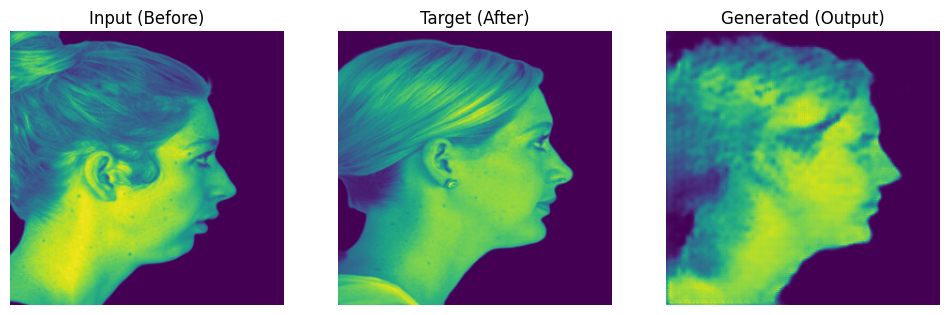

In [ ]:
import matplotlib.pyplot as plt

def generate_image(model, input_image, target):
    prediction = model(input_image, training=True)

    plt.figure(figsize=(12, 4))

    display_list = [input_image[0], target[0], prediction[0]]
    title = ['Input (Before)', 'Target (After)', 'Generated (Output)']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow((display_list[i] * 0.5 + 0.5))
        plt.axis('off')
    plt.show()

for example_input, example_target in train_dataset.take(1):
    generate_image(generator, example_input, example_target)


In [ ]:
import os

checkpoint_dir = './saved_pix2pix_model'
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

generator.save(os.path.join(checkpoint_dir, 'generator.h5'))
discriminator.save(os.path.join(checkpoint_dir, 'discriminator.h5'))

print("Generator & Discriminator models saved successfully.")

✅ Generator & Discriminator models saved successfully.


In [ ]:
def save_result_image(model, input_image, target, file_path="example_output.png"):
    if input_image.ndim == 2:
        input_image = np.expand_dims(input_image, axis=-1)

    input_tensor = tf.expand_dims(input_image, axis=0)

    prediction = model(input_tensor, training=False)[0]

    prediction = (prediction + 1) / 2

    plt.imsave(file_path, prediction.numpy().squeeze(), cmap='gray')
    print(f"🖼️ Sample generated image saved as '{file_path}'")